In [14]:
import numpy as np
import torch 
from torch_geometric.data import Data
from torch.utils.data import SubsetRandomSampler, DataLoader
import matplotlib.pyplot as plt
from deeph.data import HData
import configparser
import json


In [15]:
dataset = HData(
    raw_data_dir='/home/t.hsu/DeepRFnet/DeepDOS/work_dir/dataset/processed',
    graph_dir='/home/t.hsu/DeepRFnet/DeepDOS/work_dir/dataset/graph',
    interface='h5',
    target='hamiltonian',
    dataset_name='Bi_soc',
    multiprocessing=0,
    radius='-1.0',
    max_num_nbr=0,
    num_l='5',
    max_element='-1',
    create_from_DFT='True',
    if_lcmp_graph='True',
    separate_onsite='False',
    new_sp=False,
    default_dtype_torch=torch.get_default_dtype(),
)

In [16]:
from deeph.kernel import DeepHKernel
# Initialize the ConfigParser
config = configparser.ConfigParser()

# Read the configuration file
config.read('/home/t.hsu/deeph_dev/default.ini')

config.read('/home/t.hsu/deeph_dev/train.ini')  # Replace 'config.ini' with your actual file name

kernel = DeepHKernel(config)
train_loader, val_loader, test_loader, transform = kernel.get_dataset()


In [17]:
def make_mask(dataset):
    spinful = True
    target = 'hamiltonian'
    num_orbital = kernel.num_orbital
    dataset_mask = []
    for data in dataset:
        Oij_value = data.term_real
        if data.term_real is not None:
            if_only_rc = False

        if spinful:
            out_fea_len = num_orbital * 8

        mask = torch.zeros(data.edge_attr.shape[0], out_fea_len, dtype=torch.int8)
        label = torch.zeros(data.edge_attr.shape[0], out_fea_len, dtype=torch.get_default_dtype())

        atomic_number_edge_i = kernel.index_to_Z[data.x[data.edge_index[0]]]
        atomic_number_edge_j = kernel.index_to_Z[data.x[data.edge_index[1]]]

        for index_out, orbital_dict in enumerate(kernel.orbital):
            for N_M_str, a_b in orbital_dict.items():
                # N_M, a_b means: H_{ia, jb} when the atomic number of atom i is N and the atomic number of atom j is M
                condition_atomic_number_i, condition_atomic_number_j = map(lambda x: int(x), N_M_str.split())
                condition_orbital_i, condition_orbital_j = a_b

                if spinful:
                    if target == 'phiVdphi':
                        raise NotImplementedError("Not yet have support for phiVdphi")
                    else:
                        mask[:, 8 * index_out:8 * (index_out + 1)] = torch.where(
                            (atomic_number_edge_i == condition_atomic_number_i)
                            & (atomic_number_edge_j == condition_atomic_number_j),
                            1,
                            0
                        )[:, None].repeat(1, 8)
                else:
                    if target == 'phiVdphi':
                        mask[:, 3 * index_out:3 * (index_out + 1)] += torch.where(
                            (atomic_number_edge_i == condition_atomic_number_i)
                            & (atomic_number_edge_j == condition_atomic_number_j),
                            1,
                            0
                        )[:, None].repeat(1, 3)
                    else:
                        mask[:, index_out] += torch.where(
                            (atomic_number_edge_i == condition_atomic_number_i)
                            & (atomic_number_edge_j == condition_atomic_number_j),
                            1,
                            0
                        )

                if if_only_rc == False:
                    if spinful:
                        if target == 'phiVdphi':
                            raise NotImplementedError
                        else:
                            label[:, 8 * index_out:8 * (index_out + 1)] = torch.where(
                                (atomic_number_edge_i == condition_atomic_number_i)
                                & (atomic_number_edge_j == condition_atomic_number_j),
                                Oij_value[:, condition_orbital_i, condition_orbital_j].t(),
                                torch.zeros(8, data.edge_attr.shape[0], dtype=torch.get_default_dtype())
                            ).t()
                    else:
                        if target == 'phiVdphi':
                            label[:, 3 * index_out:3 * (index_out + 1)] = torch.where(
                                (atomic_number_edge_i == condition_atomic_number_i)
                                & (atomic_number_edge_j == condition_atomic_number_j),
                                Oij_value[:, condition_orbital_i, condition_orbital_j].t(),
                                torch.zeros(3, data.edge_attr.shape[0], dtype=torch.get_default_dtype())
                            ).t()
                        else:
                            label[:, index_out] += torch.where(
                                (atomic_number_edge_i == condition_atomic_number_i)
                                & (atomic_number_edge_j == condition_atomic_number_j),
                                Oij_value[:, condition_orbital_i, condition_orbital_j],
                                torch.zeros(data.edge_attr.shape[0], dtype=torch.get_default_dtype())
                            )
        assert len(torch.where((mask != 1) & (mask != 0))[0]) == 0
        mask = mask.bool()
        data.mask = mask
        del data.term_mask
        if if_only_rc == False:
            data.label = label
            if target == 'hamiltonian' or target == 'density_matrix':
                del data.term_real
        dataset_mask.append(data)
    return dataset_mask

In [18]:
dataset_size = len(dataset)
print(dataset_size)
print(dataset[0])
dataset = make_mask(dataset)

### In deepH approach, they take the term_real and reshape it into 19x19x8 = 2888 vector. That will be served as the "label" or the "target" for training. Similarly, I can switch that 2888 vector into other stuff. For instance, the DOS plot, or even the shift current plot.

### Now, add the DOS as the ```dataset.y```

In [19]:
# Read the data from the file
filename = '/home/t.hsu/DeepRFnet/DeepDOS/work_dir/dataset/raw/0/openmx.DOS.Gaussian'  
data = np.loadtxt(filename)

# Extract the first and second columns
energy = data[:, 0]
dos = data[:, 1]
dataset[0].label = torch.tensor(dos)

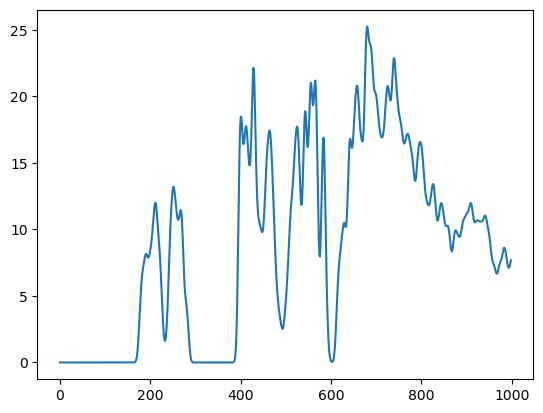

Data(
  x=[36],
  edge_index=[2, 1472],
  edge_attr=[1472, 10],
  stru_id='0',
  atom_num_orbital=[36],
  subgraph_dict={
    subgraph_atom_idx=[121080, 2],
    subgraph_edge_idx=[121080],
    subgraph_edge_ang=[121080, 25],
    subgraph_index=[121080],
  },
  spinful=[1],
  mask=[1472, 2888],
  label=[999]
)

In [20]:
plt.plot(dataset[0].label)
plt.show()
dataset[0]


In [21]:
# Iterating over the 81 graph.
for i in range(len(dataset)):
    filename = '/home/t.hsu/DeepRFnet/DeepDOS/work_dir/dataset/raw/{}/openmx.DOS.Gaussian'.format(i)
    data = np.loadtxt(filename)

    # Extract the first and second columns
    energy = data[:, 0]
    dos = data[:, 1]
    dataset[i].label = torch.tensor(dos)

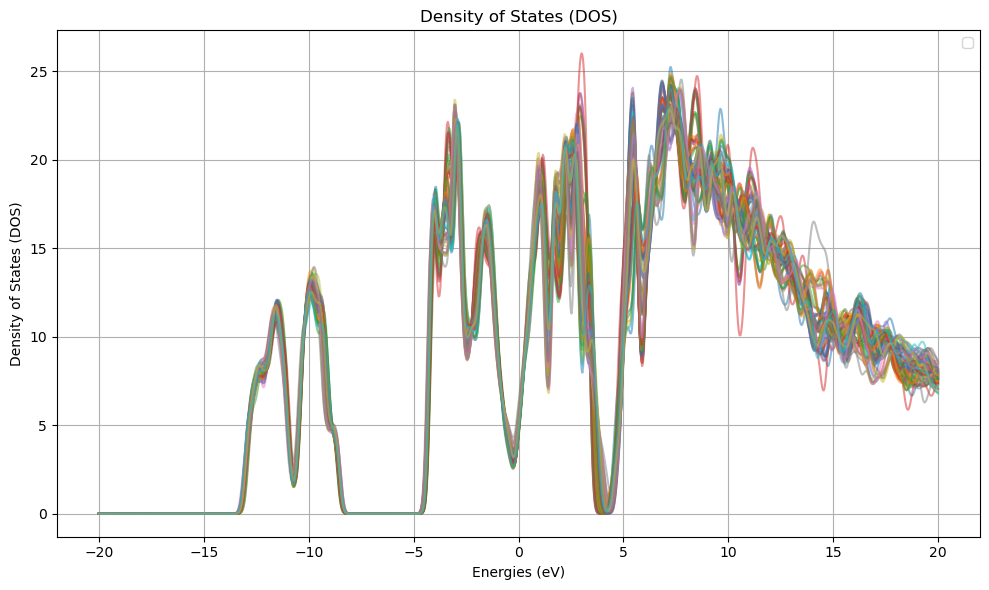

In [22]:
file_indices = range(0, 80)

all_energy = []
all_dos = []
all_occupation_numbers = []
fermi_levels = []
occupation_at_fermis = []


for i in file_indices:
    energy = data[:, 0]
    dos = dataset[i].label
    all_energy.append(energy)
    all_dos.append(dos)

# Create subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot all DOS
for energy, dos in zip(all_energy, all_dos):
    ax1.plot(energy, dos, alpha=0.5)
ax1.set_xlabel('Energies (eV)')
ax1.set_ylabel('Density of States (DOS)')
ax1.set_title('Density of States (DOS)')
ax1.grid(True)
ax1.legend()

# Show the plots
plt.tight_layout()
plt.show()



In [23]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = int(test_ratio * dataset_size)

In [24]:
indices = list(range(dataset_size))

train_sampler = SubsetRandomSampler(indices[:train_size])
val_sampler = SubsetRandomSampler(indices[train_size:train_size + val_size])
test_sampler = SubsetRandomSampler(indices[train_size + val_size:train_size + val_size + test_size])

In [25]:
from deeph.graph import Collater

train_loader = DataLoader(dataset, batch_size=1,
                            shuffle=False, sampler=train_sampler,
                            collate_fn=Collater(True))
val_loader = DataLoader(dataset, batch_size=1,
                        shuffle=False, sampler=val_sampler,
                        collate_fn=Collater(True))
test_loader = DataLoader(dataset, batch_size=1,
                            shuffle=False, sampler=test_sampler,
                            collate_fn=Collater(True))

In [26]:
train_loader.dataset

[Data(
   x=[36],
   edge_index=[2, 1472],
   edge_attr=[1472, 10],
   stru_id='0',
   atom_num_orbital=[36],
   subgraph_dict={
     subgraph_atom_idx=[121080, 2],
     subgraph_edge_idx=[121080],
     subgraph_edge_ang=[121080, 25],
     subgraph_index=[121080],
   },
   spinful=[1],
   mask=[1472, 2888],
   label=[999]
 ),
 Data(
   x=[36],
   edge_index=[2, 1462],
   edge_attr=[1462, 10],
   stru_id='1',
   atom_num_orbital=[36],
   subgraph_dict={
     subgraph_atom_idx=[119580, 2],
     subgraph_edge_idx=[119580],
     subgraph_edge_ang=[119580, 25],
     subgraph_index=[119580],
   },
   spinful=[1],
   mask=[1462, 2888],
   label=[999]
 ),
 Data(
   x=[36],
   edge_index=[2, 1456],
   edge_attr=[1456, 10],
   stru_id='10',
   atom_num_orbital=[36],
   subgraph_dict={
     subgraph_atom_idx=[118688, 2],
     subgraph_edge_idx=[118688],
     subgraph_edge_ang=[118688, 25],
     subgraph_index=[118688],
   },
   spinful=[1],
   mask=[1456, 2888],
   label=[999]
 ),
 Data(
   x=[36